## Resources

In [142]:
PROJECT_ROOT_PATH = '../../../..'
TEMP_PATH = PROJECT_ROOT_PATH + '/tmp'
DATA_PATH = TEMP_PATH + '/detect/data'

WORDS_TRAIN_PATH = DATA_PATH + '/words.train.tsv'
WORDS_TEST_PATH = DATA_PATH + '/words.test.tsv'
LABELS_TRAIN_PATH = DATA_PATH + '/labels.train.tsv'
LABELS_TEST_PATH = DATA_PATH + '/labels.test.tsv'

import glob
FEATURES_TEST_PATH = sorted(glob.glob(DATA_PATH + "/*Feature*"))
FEATURES_TEST_PATH

['../../../../tmp/detect/data/ApproximateContextCoherenceFeature$bigram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$fivegram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$fourgram.tsv',
 '../../../../tmp/detect/data/ApproximateContextCoherenceFeature$trigram.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$123.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$124.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$125.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$126.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$127.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$32.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$33.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$34.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$35.tsv',
 '../../../../tmp/detect/data/CharacterExistenceFeature$36.tsv',
 '../../../../tmp/detect/dat

## Data

In [202]:
import csv
import pandas as pd

def read_words(path):
    col_names = ["w-4", "w-3", "w-2", "w-1", "w", "w+1", "w+2", "w+3", "pos"]
    return pd.read_table(open(path, 'r'),
                         header=None,
                         quoting=csv.QUOTE_NONE,
                         names=col_names,
                        )

def read_vals(path, name=None):
    return pd.read_table(open(path, 'r'),
                         header=None,
                         names=[name],
                        )

def read_labels(path):
    return read_vals(path, 'label')

def read_feat_vals(path):
    name = path[path[:-4].rfind('/') + 1:-4]
    return read_vals(path, name)

def read_feats(paths):
    feats_vals = [read_feat_vals(p) for p in paths]
    return pd.concat(feats_vals, axis=1)

WORDS_TRAIN = read_words(WORDS_TRAIN_PATH)
WORDS_TEST  = read_words(WORDS_TEST_PATH)
LABELS_TRAIN = read_labels(LABELS_TRAIN_PATH)
LABELS_TEST  = read_labels(LABELS_TEST_PATH)

feats = read_feats(FEATURES_TEST_PATH)
FEATS_TRAIN = feats[:WORDS_TRAIN.shape[0]]
FEATS_TEST = feats[WORDS_TRAIN.shape[0]:]
feats = None

## Evaluation

In [285]:
import os
import shutil
from sklearn import metrics
from sklearn.externals import joblib
import sys
import time

FORCE_RETRAIN = False
MODEL_PATH = TEMP_PATH + '/detect/model'

def get_pkl_path(name):
    return MODEL_PATH + '/' + '%s.pkl' % name

def train(models, retrain=False):
    if FORCE_RETRAIN:
        shutil.rmtree(MODEL_PATH)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    for (name, clf) in models:
        sys.stdout.write('%-30s ..... ' % name)
        pkl_path = get_pkl_path(name)
        if not os.path.exists(pkl_path):
            str_time = time.time()
            clf.fit(FEATS_TRAIN, LABELS_TRAIN.as_matrix().ravel())
            elapsed_time = (time.time() - str_time)
            joblib.dump(clf, pkl_path, compress=9)
            print('TRAINED (%.3f seconds)' % elapsed_time)
        else:
            print('SKIPPED') 

def test(models):
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        acc = metrics.accuracy_score(LABELS_TEST, preds)
        print('%-30s ..... %.6f' % (name, acc))

def get_clf(name):
    return joblib.load(get_pkl_path(name))

### Evalutaion: Models without Optimization

In [306]:
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import neural_network
from sklearn import neighbors
from sklearn import pipeline
from sklearn import tree
from sklearn import svm

MODELS_NO_OPT = [
    ['DTree', tree.DecisionTreeClassifier()],
    ['MLP', neural_network.MLPClassifier()],
    ['KNN', neighbors.KNeighborsClassifier()],
    ['RF', ensemble.RandomForestClassifier()],
    ['AdaBoost', ensemble.AdaBoostClassifier()],
    ['ETree', ensemble.ExtraTreesClassifier()],
    ['GradBoost', ensemble.GradientBoostingClassifier()],
    ['svc', svm.SVC()],
]

In [307]:
train(MODELS_NO_OPT)

DTree                          ..... SKIPPED
MLP                            ..... SKIPPED
KNN                            ..... SKIPPED
RF                             ..... SKIPPED
AdaBoost                       ..... SKIPPED
ETree                          ..... SKIPPED
GradBoost                      ..... SKIPPED
svc                            ..... TRAINED (210.140 seconds)


In [314]:
test(MODELS_NO_OPT)

DTree                          ..... 0.980810
MLP                            ..... 0.983551
KNN                            ..... 0.983874
RF                             ..... 0.983981
AdaBoost                       ..... 0.983336
ETree                          ..... 0.984196
GradBoost                      ..... 0.984035
svc                            ..... 0.983444


## Evalutaion: Tree-Based Feature Selection

In [295]:
import numpy as np
import matplotlib.pyplot as plt

def eval_feat_importances(clf):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print(type(clf).__name__)
    print()
    
    print(sum(importances) / FEATS_TEST.shape[1])

    # Plot importance
    plt.figure(figsize=(14,5))
    plt.title('Tree-based feature importances')
    plt.bar(range(FEATS_TRAIN.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(FEATS_TRAIN.shape[1]), indices)
    plt.xlim([-1, FEATS_TRAIN.shape[1]])
    plt.show()

    # Print importance rank
    print("Feature ranking:")
    for f in range(FEATS_TRAIN.shape[1]):
        print("%2d. %-50s (%f)"
              % (f + 1, FEATS_TRAIN.columns[indices[f]], importances[indices[f]]))
        
def get_mean_importance(clf):
    importances = clf.feature_importances_
    return sum(importances) / FEATS_TEST.shape[1]

RandomForestClassifier

0.0238095238095


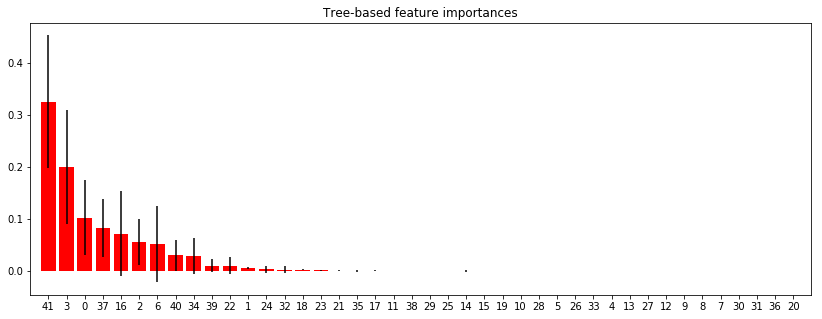

Feature ranking:
 1. WordValidityFeature                                (0.325780)
 2. ApproximateContextCoherenceFeature$trigram         (0.200525)
 3. ApproximateContextCoherenceFeature$bigram          (0.102877)
 4. ContextCoherenceFeature$bigram                     (0.082887)
 5. CharacterExistenceFeature$39                       (0.072323)
 6. ApproximateContextCoherenceFeature$fourgram        (0.055910)
 7. CharacterExistenceFeature$125                      (0.051472)
 8. ContextCoherenceFeature$trigram                    (0.030419)
 9. CharacterExistenceFeature$94                       (0.029422)
10. ContextCoherenceFeature$fourgram                   (0.010717)
11. CharacterExistenceFeature$45                       (0.010660)
12. ApproximateContextCoherenceFeature$fivegram        (0.006682)
13. CharacterExistenceFeature$47                       (0.004110)
14. CharacterExistenceFeature$92                       (0.003240)
15. CharacterExistenceFeature$41                       (0.0

In [293]:
eval_feat_importances(get_clf('RF'))

AdaBoostClassifier

0.0238095238095


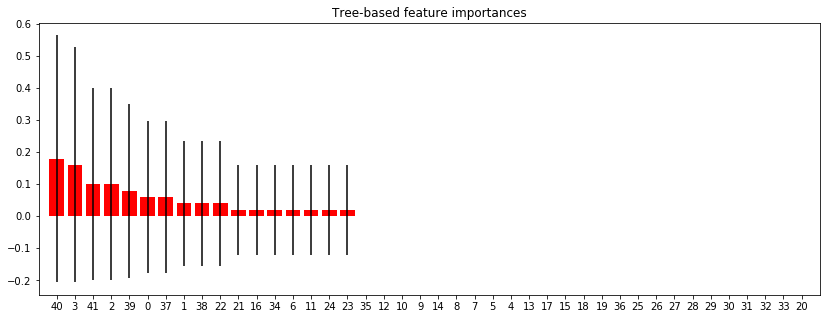

Feature ranking:
 1. ContextCoherenceFeature$trigram                    (0.180000)
 2. ApproximateContextCoherenceFeature$trigram         (0.160000)
 3. WordValidityFeature                                (0.100000)
 4. ApproximateContextCoherenceFeature$fourgram        (0.100000)
 5. ContextCoherenceFeature$fourgram                   (0.080000)
 6. ApproximateContextCoherenceFeature$bigram          (0.060000)
 7. ContextCoherenceFeature$bigram                     (0.060000)
 8. ApproximateContextCoherenceFeature$fivegram        (0.040000)
 9. ContextCoherenceFeature$fivegram                   (0.040000)
10. CharacterExistenceFeature$45                       (0.040000)
11. CharacterExistenceFeature$44                       (0.020000)
12. CharacterExistenceFeature$39                       (0.020000)
13. CharacterExistenceFeature$94                       (0.020000)
14. CharacterExistenceFeature$125                      (0.020000)
15. CharacterExistenceFeature$34                       (0.0

In [294]:
eval_feat_importances(get_clf('AdaBoost'))

ExtraTreesClassifier

0.0238095238095


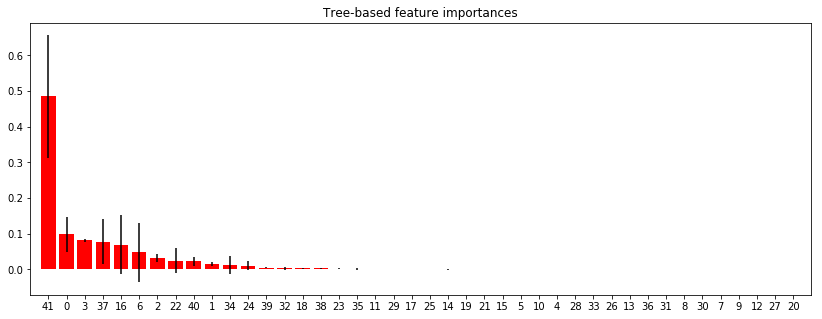

Feature ranking:
 1. WordValidityFeature                                (0.484715)
 2. ApproximateContextCoherenceFeature$bigram          (0.098709)
 3. ApproximateContextCoherenceFeature$trigram         (0.081648)
 4. ContextCoherenceFeature$bigram                     (0.077856)
 5. CharacterExistenceFeature$39                       (0.069700)
 6. CharacterExistenceFeature$125                      (0.047400)
 7. ApproximateContextCoherenceFeature$fourgram        (0.033016)
 8. CharacterExistenceFeature$45                       (0.024407)
 9. ContextCoherenceFeature$trigram                    (0.022647)
10. ApproximateContextCoherenceFeature$fivegram        (0.015885)
11. CharacterExistenceFeature$94                       (0.012934)
12. CharacterExistenceFeature$47                       (0.010899)
13. ContextCoherenceFeature$fourgram                   (0.004977)
14. CharacterExistenceFeature$92                       (0.002671)
15. CharacterExistenceFeature$41                       (0.0

In [305]:
eval_feat_importances(get_clf('ETree'))

In [330]:
from sklearn import feature_selection

MODELS_FEAT_OPT_TREE = [
    ['SFM-RF.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(get_clf('RF'))),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d5mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.5)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-RF-d1mean.RF', pipeline.Pipeline([
        ('SFM_RF', feature_selection.SelectFromModel(
            get_clf('RF'),
            threshold=get_mean_importance(get_clf('RF')) * 0.1)),
        ('RF', ensemble.RandomForestClassifier()),
        ])
    ],
    ['SFM-AdaBoost.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(get_clf('AdaBoost'))),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d5mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.5)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-AdaBoost-d1mean.AdaBoost', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('AdaBoost'),
            threshold=get_mean_importance(get_clf('AdaBoost')) * 0.1)),
        ('AdaBoost', ensemble.AdaBoostClassifier()),
        ])
    ],
    ['SFM-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection.SelectFromModel(get_clf('ETree'))),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d5mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.5)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['SFM-ETree-d1mean.ETree', pipeline.Pipeline([
        ('SFM_AdaBoost', feature_selection.SelectFromModel(
            get_clf('ETree'),
            threshold=get_mean_importance(get_clf('ETree')) * 0.1)),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
    ['RFECV-ETree', feature_selection.RFECV(
        estimator=get_clf('ETree'),
        cv=10,
        scoring='accuracy')
    ],
    ['RFECV-ETree.ETree', pipeline.Pipeline([
        ('SFM_ETree', feature_selection.RFECV(
            estimator=get_clf('ETree'),
            cv=10,
            scoring='accuracy')),
        ('ETree', ensemble.ExtraTreesClassifier()),
        ])
    ],
]

In [322]:
train(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... SKIPPED
SFM-RF-d5mean.RF               ..... SKIPPED
SFM-RF-d1mean.RF               ..... SKIPPED
SFM-AdaBoost.AdaBoost          ..... SKIPPED
SFM-AdaBoost-d5mean.AdaBoost   ..... SKIPPED
SFM-AdaBoost-d1mean.AdaBoost   ..... SKIPPED
SFM-ETree.ETree                ..... SKIPPED
SFM-ETree-d5mean.ETree         ..... SKIPPED
SFM-ETree-d1mean.ETree         ..... SKIPPED
SFM_ETree                      ..... TRAINED (156.875 seconds)
RFECV-ETree.ETree              ..... SKIPPED


In [323]:
test(MODELS_FEAT_OPT_TREE)

SFM-RF.RF                      ..... 0.983874
SFM-RF-d5mean.RF               ..... 0.984089
SFM-RF-d1mean.RF               ..... 0.983659
SFM-AdaBoost.AdaBoost          ..... 0.983229
SFM-AdaBoost-d5mean.AdaBoost   ..... 0.983336
SFM-AdaBoost-d1mean.AdaBoost   ..... 0.983336
SFM-ETree.ETree                ..... 0.984250
SFM-ETree-d5mean.ETree         ..... 0.984357
SFM-ETree-d1mean.ETree         ..... 0.983874
SFM_ETree                      ..... 0.984196
RFECV-ETree.ETree              ..... 0.984357


In [334]:
def eval_opt_feats(rfecv):
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    for name, rank in zip(FEATS_TRAIN.columns, rfecv.ranking_):
        print(name, rank)
    

Optimal number of features : 39


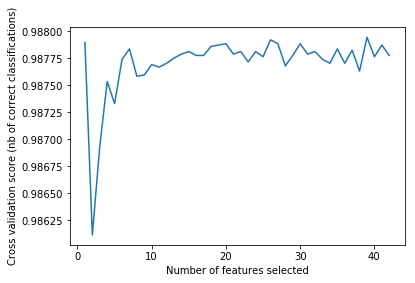

ApproximateContextCoherenceFeature$bigram 1
ApproximateContextCoherenceFeature$fivegram 1
ApproximateContextCoherenceFeature$fourgram 1
ApproximateContextCoherenceFeature$trigram 1
CharacterExistenceFeature$123 1
CharacterExistenceFeature$124 1
CharacterExistenceFeature$125 1
CharacterExistenceFeature$126 1
CharacterExistenceFeature$127 1
CharacterExistenceFeature$32 3
CharacterExistenceFeature$33 1
CharacterExistenceFeature$34 1
CharacterExistenceFeature$35 1
CharacterExistenceFeature$36 1
CharacterExistenceFeature$37 1
CharacterExistenceFeature$38 1
CharacterExistenceFeature$39 1
CharacterExistenceFeature$40 1
CharacterExistenceFeature$41 1
CharacterExistenceFeature$42 1
CharacterExistenceFeature$43 4
CharacterExistenceFeature$44 1
CharacterExistenceFeature$45 1
CharacterExistenceFeature$46 1
CharacterExistenceFeature$47 1
CharacterExistenceFeature$59 1
CharacterExistenceFeature$60 1
CharacterExistenceFeature$61 1
CharacterExistenceFeature$62 1
CharacterExistenceFeature$63 1
Characte

In [335]:
eval_opt_feats(get_clf('RFECV-ETree'))